# Data

In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

2025-05-30 20:24:21.201938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

In [3]:
duration = data[duration_col].to_numpy().squeeze()
event = data[event_col].to_numpy().squeeze()

In [4]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [5]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X = feature_scaling(X)

In [6]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize clients 

In [15]:
# NOTE: Convergence/inference issues can be realted to inter-client data heterogenity 
N_SPLITS = 2
DATA_SPLIT_IDX = np.array_split(np.arange(data.shape[0]), N_SPLITS)

In [16]:
from utils.client import Client 

participants = [] 

rho = 1

for idx in DATA_SPLIT_IDX:
    # Init client objects with mutually exclusive data samples 
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    # Apply data pre-processing steps 
    client.preprocess_data(train_test_split=False)
    # Initialize model and parameters 
    client.init_model(local_knots=False, knots=knots)

    participants.append(client)

# Initialize parameters

In [17]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration)

# Initialize beta coefficients
beta = init_beta(X, y)

# Fit clients 

In [18]:
beta_global = beta.copy()
gamma_global = gamma.copy()

beta_global_prev = np.zeros_like(beta_global)
gamma_global_prev = np.zeros_like(gamma_global)

for client in participants:
    client.set_params({"beta": beta_global, "gamma": gamma_global})

In [19]:
EPS = 1e-5
N_ITER_GLOBAL = 25000

Iter 0: 0.5130950476849665; 7.74930595961141
Iter 2500: 7.397667104669381e-06; 0.0013858078746125102
Iter 5000: 1.827775122364983e-05; 0.0011299910256639123
Iter 7500: 4.031899879919365e-05; 0.0010529527207836509
Iter 10000: 6.626627873629332e-05; 0.0008008687873370945
Iter 12500: 3.900675437762402e-05; 0.0002870418829843402
Converged after 14612 iterations


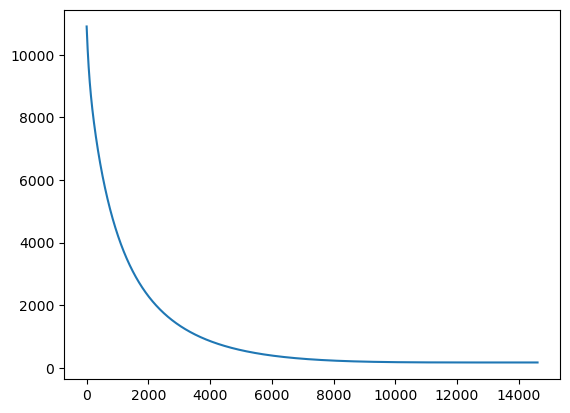

In [20]:
def has_converged(params, params_other):
    return np.linalg.norm(params_other - params) <= EPS 


# Track training performance         
losses = []

# Optimization algorithm 
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

# Optimization variables
beta_global_tf = tf.Variable(beta_global, dtype=tf.float32)
gamma_global_tf = tf.Variable(gamma_global, dtype=tf.float32)

for i in range(N_ITER_GLOBAL):

    losses_i = []
    gradients_beta, gradients_gamma = 0, 0 

    # If local data coverage of ln(t) is uneven, consider weighting local gradients based 
    # on their coverage of the lnt domain (to give more weight to underrepresented regions)
    
    for client in participants:
        # Estimate gradients     
        grad_beta, grad_gamma = client.gradients(beta_global_tf, gamma_global_tf)

        losses_i.append(client.model_loss())

        gradients_beta += grad_beta
        gradients_gamma += grad_gamma

    losses.append(np.mean(losses_i))
    
    # Run optimizer 
    optimiser.apply_gradients(zip([gradients_beta, gradients_gamma], [beta_global_tf, gamma_global_tf]))
    
    beta_global = beta_global_tf.numpy()
    gamma_global = gamma_global_tf.numpy()
    
    if has_converged(beta_global, beta_global_prev) and has_converged(gamma_global, gamma_global_prev):
        print(f"Converged after {i} iterations")
        break 

    if i % (N_ITER_GLOBAL / 10) == 0:
        change_beta = np.linalg.norm(beta_global - beta_global_prev) 
        change_gamma = np.linalg.norm(gamma_global - gamma_global_prev)
        print(f"Iter {i}: {change_beta}; {change_gamma}")

    beta_global_prev = beta_global
    gamma_global_prev = gamma_global


plt.figure()
plt.plot(losses)

In [13]:
# Save loss data to disk 
#np.save("../data/losses/rossi_gradients.npy", losses)

# Fit reference model 

Converged after 14234 iterations


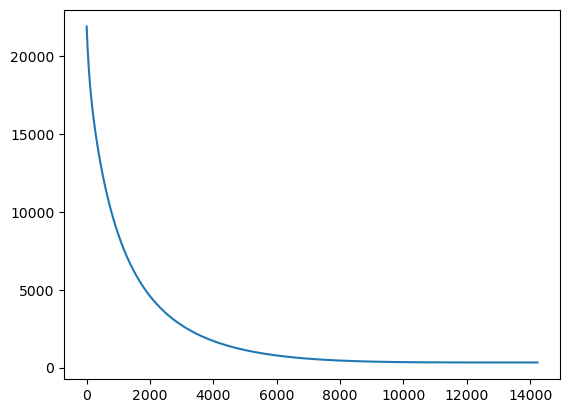

In [21]:
from utils.model import Model

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.001, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [15]:
#np.save("../data/losses/rossi_gradients_ref.npy", ref_model.losses)

In [22]:
#np.save("../data/params/rossi_gradients_beta_global_ref.npy", ref_model.beta)
ref_model.beta

array([[-0.18267497, -0.32896164,  0.09820732, -0.07598455, -0.13571073,
        -0.03848404,  0.2566436 ]], dtype=float32)

In [23]:
#np.save("../data/params/rossi_gradients_beta_global.npy", beta_global)
beta_global

array([[-0.17213736, -0.29495147,  0.11037295, -0.09334261, -0.14930852,
        -0.01999869,  0.2718462 ]], dtype=float32)

In [24]:
np.linalg.norm(ref_model.beta - beta_global)

0.04974701

In [25]:
#np.save("../data/params/rossi_gradients_gamma_global_ref.npy", ref_model.gamma)
ref_model.gamma

array([[-6.268849 , -5.0037923, -3.9059656, -2.0781016, -1.6938099,
        -1.3947159, -1.2573441]], dtype=float32)

In [26]:
#np.save("../data/params/rossi_gradients_gamma_global.npy", gamma_global)
gamma_global

array([[-5.475964 , -4.2896852, -3.6876593, -2.0466301, -1.6710703,
        -1.3746283, -1.2393541]], dtype=float32)

In [27]:
np.linalg.norm(ref_model.gamma - gamma_global)  

1.090187